# 01.3 Complete Markets and Option Pricing  

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Understand the notion of **market completeness** and its connection to replication.  
- Learn how every contingent claim $h$ can be represented by a self-financing strategy.  
- Derive the **risk-neutral pricing formula** for European options.  
- Implement the **binomial model** to price a European call and compute its hedge ratio $\Delta$.  
- Visualise both the option price tree and the replication strategy.

**This notebook follows 01.2 and uses the risk-neutral measure $\mathbb{P}^*$ to move from *no-arbitrage* to *pricing and hedging*.** 

It starts from the theoretical foundations of market completeness, then applies them to the **Cox–Ross–Rubinstein (CRR)** binomial model, where we compute the option price and the dynamic hedging strategy.


# 1. Market completeness

In a complete market, **every payoff** (e.g., option, derivative) can be *replicated*  
by a self-financing portfolio composed of the underlying and the riskless asset.

Formally, for any $\mathcal{F}_N$-measurable random variable $h$ (the payoff), there exists a self-financing strategy $\varphi$ such that:

$$
V_N(\varphi) = h.
$$

When this is possible for *all* $h$, the market is called **complete**.

Completeness ensures a **unique risk-neutral measure** $\mathbb{P}^*$, and therefore a **unique fair price** for every claim.


# 2. Risk-Neutral Valuation

Once the market is arbitrage-free and complete, the price of a contingent claim $h$ at time $n$ is:

$$
\text{Price}_n(h) = S_n^0 \, \mathbb{E}^{\mathbb{P}^*}\!\left[\frac{h}{S_N^0} \mid \mathcal{F}_n\right].
$$

At time 0:
$$
\text{Price}_0(h) = \beta_N \, \mathbb{E}^{\mathbb{P}^*}[h].
$$

Notes:
- Under $\mathbb{P}^*$, all discounted asset prices are martingales.
- The discounted portfolio value $\tilde{V}_n(\varphi)$ must also be a martingale.
- Thus, its expectation equals its initial value → defines the fair price.


# 3. Example: European Call in the Binomial Model

We now compute the price of a call option
with strike 𝐾 and maturity 
𝑁 in a 3-step binomial model.

In [1]:
import numpy as np
import pandas as pd

# Parameters
S0 = 100
K = 100
r = 0.05
U = 1.2
D = 0.8
N = 3

# Risk-neutral probability
p_star = ((1 + r) - D) / (U - D)

# All possible number of up-moves
n_up = np.arange(N + 1)
S_N = S0 * (U ** n_up) * (D ** (N - n_up))

# Payoff at maturity: European Call
h = np.maximum(S_N - K, 0)
h

array([ 0. ,  0. , 15.2, 72.8])

# 4. Backward induction (CRR pricing)

We price recursively from $n = N$ down to $n = 0$:

$$
C_n = \beta^{-1} \, \mathbb{E}^{\mathbb{P}^*}[C_{n+1} \mid \mathcal{F}_n] = \frac{1}{1+r} \left[ p^* C_u + (1 - p^*) C_d \right].
$$


In [2]:
# Backward induction
C = [h]  # terminal payoffs
for n in range(N - 1, -1, -1):
    C_next = C[0]
    C_curr = []
    for i in range(n + 1):
        val = (p_star * C_next[i + 1] + (1 - p_star) * C_next[i]) / (1 + r)
        C_curr.append(val)
    C.insert(0, C_curr)

# Convert to DataFrame
C_tree = pd.DataFrame(C, index=[f"n={i}" for i in range(N + 1)])
C_tree

,0,1,2,3
n=0,21.123529,NaN,NaN,NaN
n=1,5.385488,32.256236,NaN,NaN
n=2,0.000000,9.047619,48.761905,NaN
n=3,0.000000,0.000000,15.200000,72.8


# 5. Delta-hedging strategy (replication)

The hedge ratio (delta) at each node is computed as:

$$
\Delta_n = \frac{C_u - C_d}{S_n(U - D)}.
$$


In [3]:
Δ = []
for n in range(N):
    delta_n = []
    C_next = C[n + 1]
    for i in range(n + 1):
        S_n = S0 * (U ** i) * (D ** (n - i))
        delta_val = (C_next[i + 1] - C_next[i]) / (S_n * (U - D))
        delta_n.append(delta_val)
    Δ.append(delta_n)

Δ_tree = pd.DataFrame(Δ, index=[f"n={i}" for i in range(N)])
Δ_tree


,0,1,2
n=0,0.671769,NaN,NaN
n=1,0.282738,0.827381,NaN
n=2,0.000000,0.395833,1.0


# 6. Visualization: price and delta trees

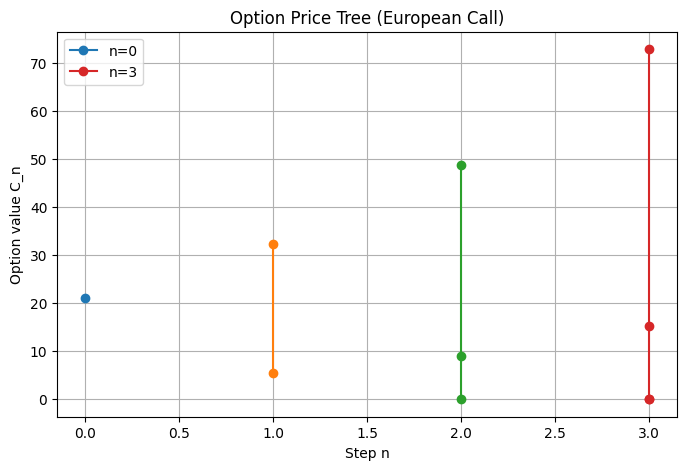

In [4]:
import matplotlib.pyplot as plt

# Extract prices at each node (flattened)
levels = [np.arange(n + 1) for n in range(N + 1)]
prices = [C_tree.loc[f"n={n}"].values for n in range(N + 1)]

plt.figure(figsize=(8,5))
for n, vals in enumerate(prices):
    plt.plot([n]*len(vals), vals, 'o-', label=f"n={n}" if n in [0,N] else "")
plt.title("Option Price Tree (European Call)")
plt.xlabel("Step n")
plt.ylabel("Option value C_n")
plt.legend()
plt.grid(True)
plt.show()


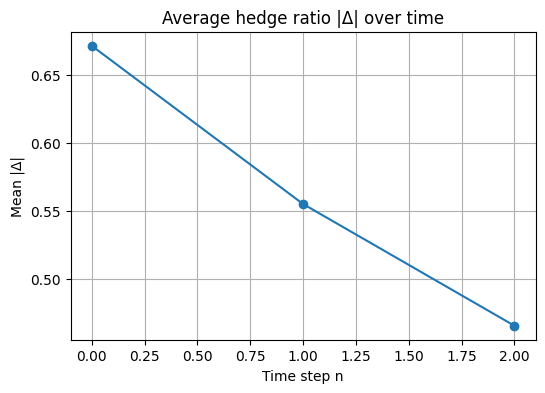

In [5]:
# Delta over time (average across nodes for visual trend)
mean_delta = [np.mean(np.abs(d)) for d in Δ]
plt.figure(figsize=(6,4))
plt.plot(range(N), mean_delta, marker='o')
plt.title("Average hedge ratio |Δ| over time")
plt.xlabel("Time step n")
plt.ylabel("Mean |Δ|")
plt.grid(True)
plt.show()

# Notes:

**Option Price Tree plot**  
- The tree shows how the European call value evolves backward through time.  
- At maturity $n = 3$, the red points represent the option payoffs $\max(S_N - K, 0)$: the option is only valuable when the underlying finishes above the strike.  
- Moving backward (green → orange → blue), each node value corresponds to the **expected discounted value** of the next-step prices under the risk-neutral probability $p^*$.  
- The initial price (blue, $C_0 \approx 21$) is therefore the fair value of the option (the cost of setting up the portfolio that will perfectly replicate the call payoff).

**Average hedge ratio $|\Delta|$ plot**  
- The hedge ratio $\Delta_n$ measures the number of shares of the underlying to hold per option in order to remain perfectly hedged.  
- The average $|\Delta|$ decreases over time: early in the life of the option, the portfolio is more sensitive to stock price changes (higher delta).  
- As maturity approaches, the option's payoff becomes less reactive to small price moves, and the hedge ratio gradually declines.  
- This behaviour reflects the **dynamic replication** mechanism: rebalancing the portfolio as the option moves closer to expiry.

